## 28. Pix2Pix with HANGUL JAMO

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 28.1 Loading Data

In [3]:
source_dir = "./FontGen/image_pair/source"
source_data = dsets.ImageFolder(source_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

In [4]:
target_dir = "./FontGen/image_pair/target"
target_data = dsets.ImageFolder(target_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

In [5]:
batch_size = 20

target_loader  = torch.utils.data.DataLoader(dataset=target_data,
                                           batch_size=batch_size,
                                           shuffle=False)

source_loader = torch.utils.data.DataLoader(dataset=source_data,
                                         batch_size=batch_size,
                                         shuffle=False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

## 28.2 Define Model

In [7]:
def downconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2, inplace=True))

    else : 
        conv.append(nn.ReLU(inplace=True))

    return nn.Sequential(*conv)

def upconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.Dropout2d(0.5),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2, inplace=True))
    else : 
        conv.append(nn.ReLU(inplace=True))

    return nn.Sequential(*conv)

In [8]:
class Generator(nn.Module) :
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c1 = downconvs(1, 16, 2, True)       
        self.c2 = downconvs(16, 32, 2, True)        
        self.c3 = downconvs(32, 64, 3, True)        
        self.c4 = downconvs(64, 128, 2, True)
        self.c5 = nn.Sequential(
            nn.Conv2d(128, 256, 2, stride=2, padding=0),
            nn.ReLU(inplace=True)
        )
        
        self.uc1 = upconvs(256, 128, 2, True)
        self.uc2 = upconvs(256, 64, 2, True)
        self.uc3 = upconvs(128, 32, 3, True)
        self.uc4 = upconvs(64, 16, 2, True)
        
        self.uc5 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
            nn.Tanh()
        )
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x) :
        
        x1 = self.c1(x)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)
        x5 = self.c5(x4)
        
        out = torch.cat([x4,self.uc1(x5)], 1)
        out = torch.cat([x3,self.uc2(out)], 1)
        out = torch.cat([x2,self.uc3(out)], 1)
        out = torch.cat([x1,self.uc4(out)], 1)
        
        out = self.uc5(out)
        out = self.relu(out)
        
        return out

In [9]:
G = Generator().cuda()

In [10]:
z = Variable(torch.randn((1, 1, 36, 36)))
G(z.cuda())

Variable containing:
(0 ,0 ,.,.) = 
  0.0541  0.0000  0.0000  ...   0.0000  0.0123  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0200  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0083  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0036  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 1x1x36x36 (GPU 0)]

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(2, 32, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=2, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.main(x)
        out = out.view(-1, 1)
        
        return out

In [12]:
D = Discriminator().cuda()

In [13]:
z = Variable(torch.randn((1, 2, 36, 36)))
D(z.cuda())

Variable containing:
 0.5195
 0.5376
 0.5175
 0.5215
 0.5833
 0.5276
 0.5193
 0.5333
 0.5651
 0.5150
 0.5116
 0.4861
 0.5173
 0.5421
 0.5232
 0.5546
[torch.cuda.FloatTensor of size 16x1 (GPU 0)]

## 28.3 Model Training

In [14]:
l1_loss = nn.L1Loss()

In [15]:
def gan_loss(x, target_is_real):
    
    loss = nn.MSELoss()
    
    if target_is_real : 
        target_tensor = torch.FloatTensor([1.0]*batch_size*16)
    else :
        target_tensor = torch.FloatTensor([0.0]*batch_size*16)
        
    return loss(x, Variable(target_tensor).cuda())

In [16]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [17]:
num_epoch = 25

Epoch [1/25], lter [10/36], D_Loss: 0.2336, G_Loss: 448.1938
Epoch [1/25], lter [20/36], D_Loss: 0.2232, G_Loss: 431.3958
Epoch [1/25], lter [30/36], D_Loss: 0.2075, G_Loss: 454.0060
Epoch [2/25], lter [10/36], D_Loss: 0.1856, G_Loss: 442.9955
Epoch [2/25], lter [20/36], D_Loss: 0.1728, G_Loss: 425.7669
Epoch [2/25], lter [30/36], D_Loss: 0.1487, G_Loss: 448.6469
Epoch [3/25], lter [10/36], D_Loss: 0.1214, G_Loss: 435.8849
Epoch [3/25], lter [20/36], D_Loss: 0.1072, G_Loss: 418.3342
Epoch [3/25], lter [30/36], D_Loss: 0.0806, G_Loss: 439.9401
Epoch [4/25], lter [10/36], D_Loss: 0.0584, G_Loss: 427.2106
Epoch [4/25], lter [20/36], D_Loss: 0.0503, G_Loss: 409.7769
Epoch [4/25], lter [30/36], D_Loss: 0.0319, G_Loss: 430.8040
Epoch [5/25], lter [10/36], D_Loss: 0.0236, G_Loss: 417.7366
Epoch [5/25], lter [20/36], D_Loss: 0.0229, G_Loss: 397.7978
Epoch [5/25], lter [30/36], D_Loss: 0.0137, G_Loss: 419.6632


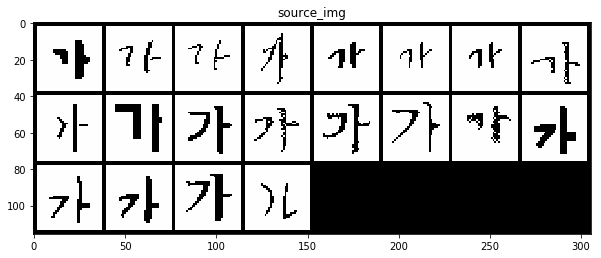

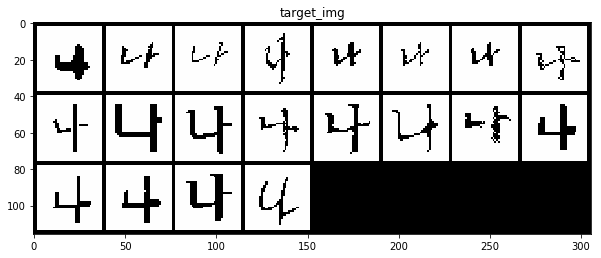

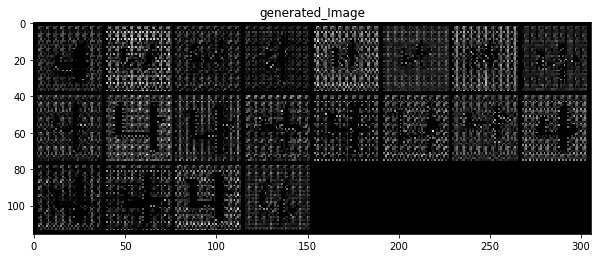

Epoch [6/25], lter [10/36], D_Loss: 0.0118, G_Loss: 406.5376
Epoch [6/25], lter [20/36], D_Loss: 0.0132, G_Loss: 387.5484
Epoch [6/25], lter [30/36], D_Loss: 0.0078, G_Loss: 407.4395
Epoch [7/25], lter [10/36], D_Loss: 0.0076, G_Loss: 393.9415
Epoch [7/25], lter [20/36], D_Loss: 0.0093, G_Loss: 374.5322
Epoch [7/25], lter [30/36], D_Loss: 0.0047, G_Loss: 393.2889
Epoch [8/25], lter [10/36], D_Loss: 0.0054, G_Loss: 377.4265
Epoch [8/25], lter [20/36], D_Loss: 0.0076, G_Loss: 361.4463
Epoch [8/25], lter [30/36], D_Loss: 0.0039, G_Loss: 378.6052
Epoch [9/25], lter [10/36], D_Loss: 0.0047, G_Loss: 365.1363
Epoch [9/25], lter [20/36], D_Loss: 0.0070, G_Loss: 349.0636
Epoch [9/25], lter [30/36], D_Loss: 0.0032, G_Loss: 363.4143
Epoch [10/25], lter [10/36], D_Loss: 0.0038, G_Loss: 352.1707
Epoch [10/25], lter [20/36], D_Loss: 0.0059, G_Loss: 330.5493
Epoch [10/25], lter [30/36], D_Loss: 0.0031, G_Loss: 351.8106


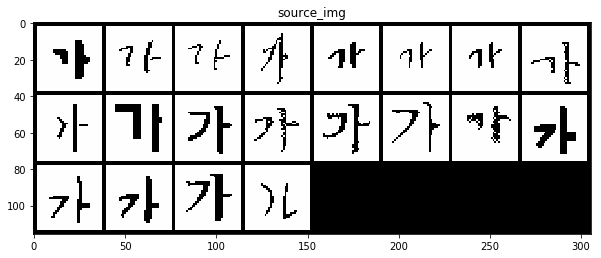

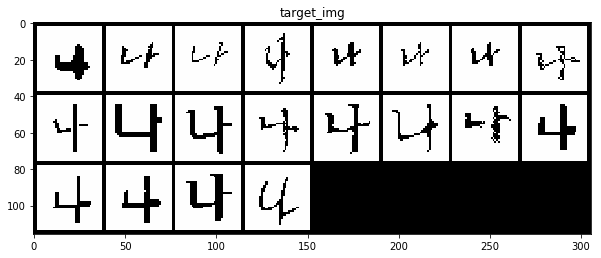

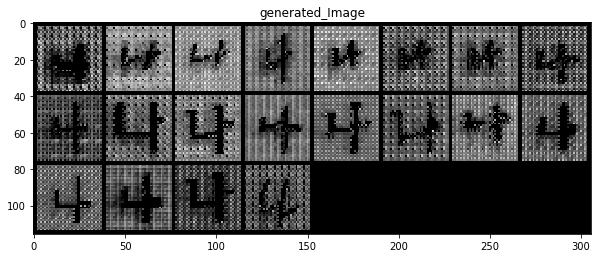

Epoch [11/25], lter [10/36], D_Loss: 0.0036, G_Loss: 333.4780
Epoch [11/25], lter [20/36], D_Loss: 0.0057, G_Loss: 317.0919
Epoch [11/25], lter [30/36], D_Loss: 0.0027, G_Loss: 333.5865
Epoch [12/25], lter [10/36], D_Loss: 0.0039, G_Loss: 321.1674
Epoch [12/25], lter [20/36], D_Loss: 0.0056, G_Loss: 300.8382
Epoch [12/25], lter [30/36], D_Loss: 0.0030, G_Loss: 320.6141
Epoch [13/25], lter [10/36], D_Loss: 0.0035, G_Loss: 303.3341
Epoch [13/25], lter [20/36], D_Loss: 0.0062, G_Loss: 289.2669
Epoch [13/25], lter [30/36], D_Loss: 0.0029, G_Loss: 302.2575
Epoch [14/25], lter [10/36], D_Loss: 0.0046, G_Loss: 290.3524
Epoch [14/25], lter [20/36], D_Loss: 0.0073, G_Loss: 274.3357
Epoch [14/25], lter [30/36], D_Loss: 0.0033, G_Loss: 286.0134
Epoch [15/25], lter [10/36], D_Loss: 0.0041, G_Loss: 272.6531
Epoch [15/25], lter [20/36], D_Loss: 0.0064, G_Loss: 258.7023
Epoch [15/25], lter [30/36], D_Loss: 0.0049, G_Loss: 273.2438


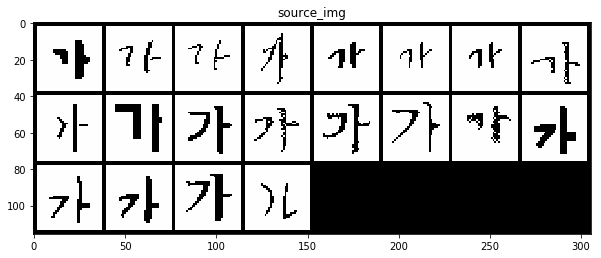

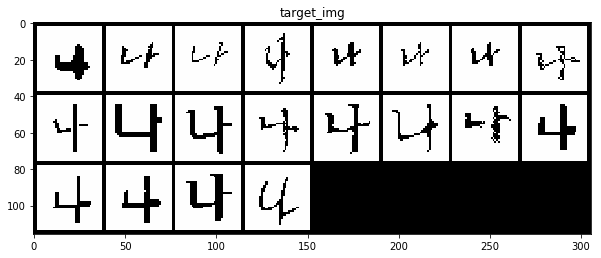

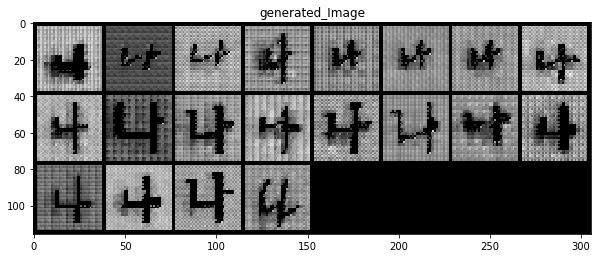

Epoch [16/25], lter [10/36], D_Loss: 0.0032, G_Loss: 262.8829
Epoch [16/25], lter [20/36], D_Loss: 0.0093, G_Loss: 245.0298
Epoch [16/25], lter [30/36], D_Loss: 0.0030, G_Loss: 256.6816
Epoch [17/25], lter [10/36], D_Loss: 0.0065, G_Loss: 245.4780
Epoch [17/25], lter [20/36], D_Loss: 0.0093, G_Loss: 231.4714
Epoch [17/25], lter [30/36], D_Loss: 0.0063, G_Loss: 244.5049
Epoch [18/25], lter [10/36], D_Loss: 0.0044, G_Loss: 232.4496
Epoch [18/25], lter [20/36], D_Loss: 0.0119, G_Loss: 222.4613
Epoch [18/25], lter [30/36], D_Loss: 0.0040, G_Loss: 233.5326
Epoch [19/25], lter [10/36], D_Loss: 0.0068, G_Loss: 221.3014
Epoch [19/25], lter [20/36], D_Loss: 0.0117, G_Loss: 207.4614
Epoch [19/25], lter [30/36], D_Loss: 0.0045, G_Loss: 219.4236
Epoch [20/25], lter [10/36], D_Loss: 0.0051, G_Loss: 211.9211
Epoch [20/25], lter [20/36], D_Loss: 0.0107, G_Loss: 202.9162
Epoch [20/25], lter [30/36], D_Loss: 0.0064, G_Loss: 208.4432


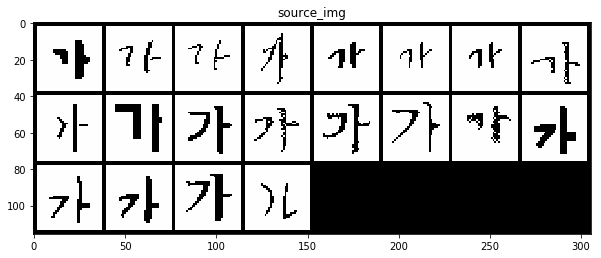

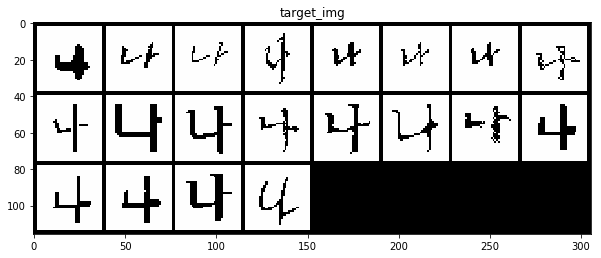

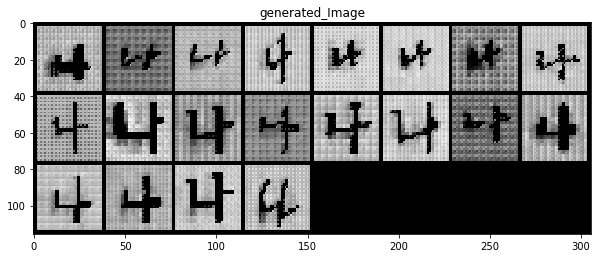

Epoch [21/25], lter [10/36], D_Loss: 0.0090, G_Loss: 197.2199
Epoch [21/25], lter [20/36], D_Loss: 0.0169, G_Loss: 191.1176
Epoch [21/25], lter [30/36], D_Loss: 0.0073, G_Loss: 199.3462
Epoch [22/25], lter [10/36], D_Loss: 0.0066, G_Loss: 192.4042
Epoch [22/25], lter [20/36], D_Loss: 0.0179, G_Loss: 179.6073
Epoch [22/25], lter [30/36], D_Loss: 0.0051, G_Loss: 186.5703
Epoch [23/25], lter [10/36], D_Loss: 0.0057, G_Loss: 181.1175
Epoch [23/25], lter [20/36], D_Loss: 0.0210, G_Loss: 174.8893
Epoch [23/25], lter [30/36], D_Loss: 0.0083, G_Loss: 177.5958
Epoch [24/25], lter [10/36], D_Loss: 0.0097, G_Loss: 173.9706
Epoch [24/25], lter [20/36], D_Loss: 0.0152, G_Loss: 162.2414
Epoch [24/25], lter [30/36], D_Loss: 0.0098, G_Loss: 165.8018
Epoch [25/25], lter [10/36], D_Loss: 0.0124, G_Loss: 162.4930
Epoch [25/25], lter [20/36], D_Loss: 0.0200, G_Loss: 161.7973
Epoch [25/25], lter [30/36], D_Loss: 0.0059, G_Loss: 163.5933


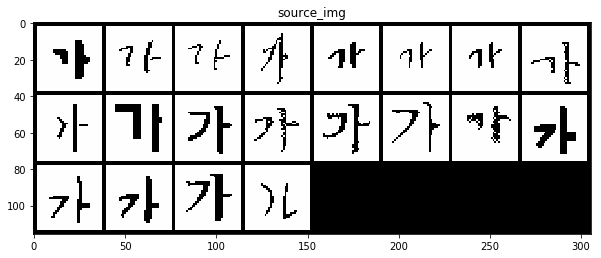

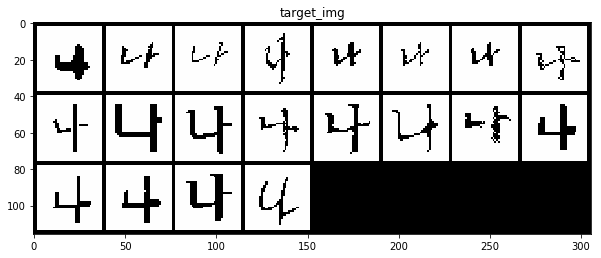

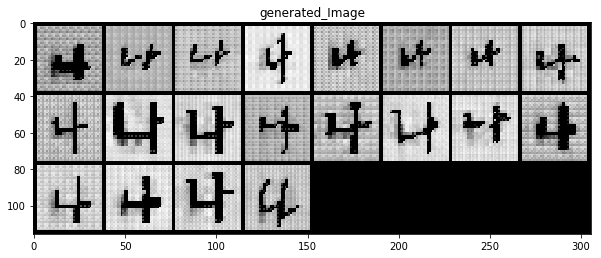

In [18]:
for epoch in range(num_epoch) :
    
    total_batch = len(target_data) // batch_size
    
    for i, (target_img, target_label) in enumerate(target_loader) : 
        for j, (source_img, source_label) in enumerate(source_loader) :

            if i != j : continue

            target_img = Variable(target_img).cuda()
            source_img = Variable(source_img).cuda()
            
            prob_real = D(torch.cat([target_img,source_img], 1))
            D_loss_real = gan_loss(prob_real, True)

            fake_img = G(source_img)
            prob_fake = D(torch.cat([fake_img,source_img], 1))
            D_loss_fake = gan_loss(prob_fake, False)

            D_loss = (D_loss_real + D_loss_fake) * 0.5

            D.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            fake_img = G(source_img)
            prob_fake = D(torch.cat([fake_img,source_img], 1))
            G_loss_fake = gan_loss(prob_fake, True)
            G_loss_L1 = l1_loss(fake_img, target_img)

            G_loss = G_loss_fake + G_loss_L1 * 500

            G.zero_grad()
            G_loss.backward()
            G_optimizer.step()
    
        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epoch, i+1, total_batch, D_loss.data[0], G_loss.data[0]))
            
    if (epoch+1) % 5 == 0 :
        source_dataiter = iter(source_loader)

        images, labels = source_dataiter.next()
        imshow(torchvision.utils.make_grid(images, normalize=True), "source_img")

        target_dataiter = iter(target_loader)

        images, labels = target_dataiter.next()
        imshow(torchvision.utils.make_grid(images, normalize=True), "target_img")

        imshow(torchvision.utils.make_grid(G(Variable(images).cuda()).data.cpu().float(), normalize=True), "generated_Image")

## 28.4 Test Model

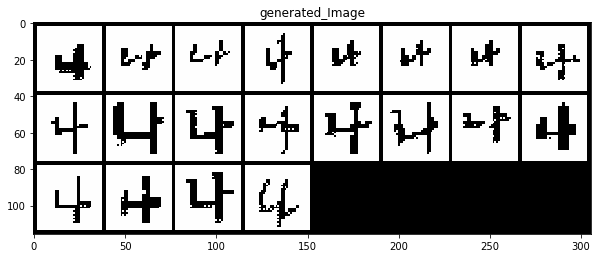

In [19]:
thresh_hold = 0.3
imshow(torchvision.utils.make_grid((G(Variable(images).cuda()).data.cpu()>thresh_hold).float(), normalize=True), "generated_Image")